# Import library

In [44]:
import pandas as pd
import numpy as np
import random
import datetime
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


# Dataset Configuration

In [45]:
# Memuat dataset
try:
    df_mk = pd.read_csv('./mk_dsi.csv')
    df_ruang = pd.read_csv('./ruang_kuliah.csv')

    # --- PERBAIKAN ---
    # Langsung ganti nama kolom setelah memuat untuk menghindari error
    # dan membuat kode lebih robust (tahan banting).
    # Format nama kolom di file CSV: 'Kode MK', 'Nama MK', ..., 'Nama Dosen'
    df_mk.columns = ['kode_mk', 'nama_mk', 'prodi', 'prioritas', 'berminat', 'dosen_id']
    df_ruang.columns = ['kode_ruang', 'lokasi', 'lantai', 'keterangan']

    # Sekarang gunakan nama kolom baru ('dosen_id') untuk operasi selanjutnya
    # Mengisi nilai kosong di kolom dosen_id.
    df_mk['dosen_id'] = df_mk['dosen_id'].fillna('Belum Ada Dosen')
    # Mengubah tipe data kolom dosen_id agar konsisten (semua menjadi string)
    df_mk['dosen_id'] = df_mk['dosen_id'].astype(str)

except FileNotFoundError:
    print("--- GAGAL MEMUAT FILE ---")
    print("Pastikan file 'mk_dsi.csv' dan 'ruang_kuliah.csv' ada di direktori yang sama dengan notebook ini.")
    df_mk, df_ruang = pd.DataFrame(), pd.DataFrame() # Buat dataframe kosong jika gagal

# Cek apakah dataframe berhasil dimuat sebelum melanjutkan
if not df_mk.empty:
    # Mengambil list unik dari mata kuliah berdasarkan kode_mk
    list_mk_unique = df_mk.drop_duplicates(subset=['kode_mk']).to_dict('records')

    # Mengelompokkan semua dosen yang mengajar satu MK berdasarkan kode_mk
    dosen_per_mk = df_mk.groupby('kode_mk')['dosen_id'].apply(list).to_dict()

    # Memasukkan daftar dosen ke setiap mata kuliah unik
    for mk in list_mk_unique:
        mk['dosen_list'] = dosen_per_mk.get(mk['kode_mk'], [])

    list_ruang = df_ruang['kode_ruang'].unique().tolist()

    print("Pemuatan dan pra-pemrosesan data berhasil.")
    print(f"Total Mata Kuliah Unik yang akan dijadwalkan: {len(list_mk_unique)}")
    print(f"Total Ruangan Tersedia: {len(list_ruang)}")
else:
    print("\nDataFrame kosong karena file tidak ditemukan. Eksekusi sel berikutnya kemungkinan akan gagal.")

Pemuatan dan pra-pemrosesan data berhasil.
Total Mata Kuliah Unik yang akan dijadwalkan: 137
Total Ruangan Tersedia: 44


# Define Time Slot & Rooms

In [33]:
# --- Definisi Slot Waktu ---
def generate_time_slots():
    slots = []
    days = {"Senin": 0, "Selasa": 1, "Rabu": 2, "Kamis": 3, "Jumat": 4}
    
    for day_name, day_index in days.items():
        start_time = datetime.datetime.strptime("07:00", "%H:%M")
        end_time = datetime.datetime.strptime("18:00", "%H:%M")
        
        if day_name in ["Senin", "Selasa", "Rabu", "Kamis"]:
            break_start = datetime.datetime.strptime("12:10", "%H:%M")
            break_end = datetime.datetime.strptime("12:30", "%H:%M")
        else: # Jumat
            break_start = datetime.datetime.strptime("11:15", "%H:%M")
            break_end = datetime.datetime.strptime("12:30", "%H:%M")
        
        current_time = start_time
        while current_time < end_time:
            slot_end_time = current_time + datetime.timedelta(minutes=50)
            if not (current_time >= break_start and current_time < break_end):
                 slots.append(f"{day_name}_{current_time.strftime('%H:%M')}-{slot_end_time.strftime('%H:%M')}")
            current_time = slot_end_time
            
    # Menambahkan slot khusus untuk pelajaran agama non-islam di hari Jumat
    # Asumsi: kita sediakan slotnya, penugasan MK-nya memerlukan logika tambahan
    special_break_start = datetime.datetime.strptime("11:15", "%H:%M")
    special_slot_end = special_break_start + datetime.timedelta(minutes=50)
    slots.append(f"Jumat_{special_break_start.strftime('%H:%M')}-{special_slot_end.strftime('%H:%M')}_AGAMA_KHUSUS")

    return slots

time_slots = generate_time_slots()

# --- Definisi Ruangan ---
ruang_lab = [r['kode_ruang'] for i, r in df_ruang.iterrows() if 'lab' in r['keterangan'].lower()]
ruang_reguler = [r for r in list_ruang if r not in ruang_lab]

# Menandai MK yang memerlukan lab
for mk in list_mk_unique:
    mk['jenis'] = 'lab' if 'praktikum' in mk['nama_mk'].lower() else 'reguler'

print(f"Total Slot Waktu Tersedia: {len(time_slots)}")
print(f"Total Ruang Reguler: {len(ruang_reguler)}, Total Ruang Lab: {len(ruang_lab)}")

Total Slot Waktu Tersedia: 70
Total Ruang Reguler: 44, Total Ruang Lab: 0


# Function to Evaluate

In [34]:
HARD_CONSTRAINT_PENALTY = 100
SOFT_CONSTRAINT_PENALTY = 1

def calculate_fitness(schedule, df_ruang_details, time_slots_list):
    """Menghitung skor fitness untuk satu jadwal (solusi). Semakin rendah semakin baik."""
    hard_violations = 0
    soft_score = 0
    
    room_time_usage = defaultdict(int)
    dosen_time_usage = defaultdict(list)

    # Iterasi untuk setiap alokasi MK dalam jadwal
    for slot in schedule:
        # Hard Constraint #1: Konflik Ruang dan Waktu
        room_time_key = (slot['ruang'], slot['waktu'])
        room_time_usage[room_time_key] += 1
        if room_time_usage[room_time_key] > 1:
            hard_violations += 1
            
        # Hard Constraint #2 & #3: Konflik Dosen
        for dosen in slot['dosen_list']:
            if dosen in dosen_time_usage[slot['waktu']]:
                hard_violations += 1
            dosen_time_usage[slot['waktu']].append(dosen)

    # Soft Constraint #1: Prioritas MK
    total_priority = sum(s['prioritas'] for s in schedule)
    soft_score += total_priority

    # Soft Constraint #2: Pergerakan Dosen
    dosen_schedule = defaultdict(list)
    for s in schedule:
        for dosen in s['dosen_list']:
            dosen_schedule[dosen].append({'waktu': s['waktu'], 'ruang': s['ruang']})

    for dosen, movements in dosen_schedule.items():
        if len(movements) > 1:
            sorted_movements = sorted(movements, key=lambda x: time_slots_list.index(x['waktu']))
            for i in range(len(sorted_movements) - 1):
                # Cek jika jadwal berurutan
                if time_slots_list.index(sorted_movements[i+1]['waktu']) == time_slots_list.index(sorted_movements[i]['waktu']) + 1:
                    try:
                        lantai_1 = df_ruang_details[df_ruang_details['kode_ruang'] == sorted_movements[i]['ruang']]['lantai'].iloc[0]
                        lantai_2 = df_ruang_details[df_ruang_details['kode_ruang'] == sorted_movements[i+1]['ruang']]['lantai'].iloc[0]
                        perbedaan_lantai = abs(lantai_1 - lantai_2)
                        if perbedaan_lantai > 1:
                            soft_score += perbedaan_lantai * SOFT_CONSTRAINT_PENALTY
                    except IndexError:
                        continue # Ruang tidak ditemukan

    return (hard_violations * HARD_CONSTRAINT_PENALTY) + soft_score, hard_violations

# Fungsi bantuan untuk membuat jadwal acak
def create_random_schedule(courses, rooms_reg, rooms_lab, times):
    schedule = []
    for course in courses:
        slot = copy.deepcopy(course)
        slot['ruang'] = random.choice(rooms_lab) if course['jenis'] == 'lab' else random.choice(rooms_reg)
        slot['waktu'] = random.choice(times)
        schedule.append(slot)
    return schedule

# Implementing PSO

In [35]:
class Particle:
    def __init__(self, courses, rooms_reg, rooms_lab, times):
        self.position = create_random_schedule(courses, rooms_reg, rooms_lab, times)
        self.velocity = [0] * len(courses) # Velocity sederhana, bisa dikembangkan
        self.best_position = copy.deepcopy(self.position)
        self.fitness, self.violations = float('inf'), float('inf')
        self.best_fitness = float('inf')

def pso_optimizer(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list,
                  n_particles=30, n_iterations=100, w=0.5, c1=1.5, c2=1.5):
    
    swarm = [Particle(courses, rooms_reg, rooms_lab, times) for _ in range(n_particles)]
    global_best_position = None
    global_best_fitness = float('inf')
    fitness_history = []

    for i in range(n_iterations):
        for particle in swarm:
            particle.fitness, particle.violations = calculate_fitness(particle.position, df_ruang_details, time_slots_list)
            
            if particle.fitness < particle.best_fitness:
                particle.best_fitness = particle.fitness
                particle.best_position = copy.deepcopy(particle.position)
            
            if particle.fitness < global_best_fitness:
                global_best_fitness = particle.fitness
                global_best_position = copy.deepcopy(particle.position)

        # Update velocity and position
        for particle in swarm:
            new_position = copy.deepcopy(particle.position)
            for j in range(len(courses)):
                # Cognitive component (menuju pbest)
                if random.random() < c1:
                    new_position[j]['ruang'] = particle.best_position[j]['ruang']
                    new_position[j]['waktu'] = particle.best_position[j]['waktu']
                
                # Social component (menuju gbest)
                if random.random() < c2:
                    new_position[j]['ruang'] = global_best_position[j]['ruang']
                    new_position[j]['waktu'] = global_best_position[j]['waktu']
            
            particle.position = new_position
        
        fitness_history.append(global_best_fitness)
        print(f"PSO Iteration {i+1}/{n_iterations} | Best Fitness: {global_best_fitness}")
        
    final_fitness, final_violations = calculate_fitness(global_best_position, df_ruang_details, time_slots_list)
    return global_best_position, final_fitness, final_violations, fitness_history

# Run the PSO Algorithm

In [36]:
print("\n--- Menjalankan Particle Swarm Optimization ---")
PSO_PARTICLES = 50
PSO_ITERATIONS = 50

pso_best_schedule, pso_fitness, pso_violations, pso_history = pso_optimizer(
    list_mk_unique, ruang_reguler, ruang_lab, time_slots, df_ruang, time_slots,
    n_particles=PSO_PARTICLES, n_iterations=PSO_ITERATIONS
)

print("\n--- Hasil PSO ---")
print(f"Skor Fitness Terbaik: {pso_fitness}")
print(f"Jumlah Pelanggaran Hard Constraint: {pso_violations}")
pd.DataFrame(pso_best_schedule).to_csv('jadwal_pso.csv', index=False)
print("Jadwal terbaik dari PSO disimpan sebagai 'jadwal_pso.csv'")


--- Menjalankan Particle Swarm Optimization ---
PSO Iteration 1/50 | Best Fitness: 20677
PSO Iteration 2/50 | Best Fitness: 20677
PSO Iteration 3/50 | Best Fitness: 20677
PSO Iteration 4/50 | Best Fitness: 20677
PSO Iteration 5/50 | Best Fitness: 20677
PSO Iteration 6/50 | Best Fitness: 20677
PSO Iteration 7/50 | Best Fitness: 20677
PSO Iteration 8/50 | Best Fitness: 20677
PSO Iteration 9/50 | Best Fitness: 20677
PSO Iteration 10/50 | Best Fitness: 20677
PSO Iteration 11/50 | Best Fitness: 20677
PSO Iteration 12/50 | Best Fitness: 20677
PSO Iteration 13/50 | Best Fitness: 20677
PSO Iteration 14/50 | Best Fitness: 20677
PSO Iteration 15/50 | Best Fitness: 20677
PSO Iteration 16/50 | Best Fitness: 20677
PSO Iteration 17/50 | Best Fitness: 20677
PSO Iteration 18/50 | Best Fitness: 20677
PSO Iteration 19/50 | Best Fitness: 20677
PSO Iteration 20/50 | Best Fitness: 20677
PSO Iteration 21/50 | Best Fitness: 20677
PSO Iteration 22/50 | Best Fitness: 20677
PSO Iteration 23/50 | Best Fitness: 

# Implementing Ant Colony Optimization (ACO)

In [37]:
def aco_optimizer(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list,
                  n_ants=10, n_iterations=100, alpha=1.0, beta=2.0, evaporation_rate=0.5):

    pheromones = defaultdict(lambda: 1.0)
    best_schedule_overall = None
    best_fitness_overall = float('inf')
    fitness_history = []

    for i in range(n_iterations):
        schedules = []
        for ant in range(n_ants):
            schedule = []
            available_courses = copy.deepcopy(courses)
            random.shuffle(available_courses)
            
            for course in available_courses:
                # Memilih kombinasi ruang & waktu
                choices = []
                possible_rooms = rooms_lab if course['jenis'] == 'lab' else rooms_reg
                for room in possible_rooms:
                    for time in times:
                        # Heuristic (sederhana): preferensi acak
                        heuristic = random.random() 
                        pheromone_level = pheromones[(course['kode_mk'], room, time)]
                        prob = (pheromone_level ** alpha) * (heuristic ** beta)
                        choices.append({'prob': prob, 'room': room, 'time': time})
                
                # Normalisasi probabilitas dan pilih
                total_prob = sum(c['prob'] for c in choices)
                if total_prob == 0: # Jika tidak ada pilihan, pilih acak
                    chosen_room = random.choice(possible_rooms)
                    chosen_time = random.choice(times)
                else:
                    r = random.uniform(0, total_prob)
                    upto = 0
                    for c in choices:
                        if upto + c['prob'] >= r:
                            chosen_room = c['room']
                            chosen_time = c['time']
                            break
                        upto += c['prob']

                slot = copy.deepcopy(course)
                slot['ruang'] = chosen_room
                slot['waktu'] = chosen_time
                schedule.append(slot)
            
            schedules.append(schedule)

        # Evaporasi feromon
        for key in pheromones:
            pheromones[key] *= (1 - evaporation_rate)

        # Deposit feromon oleh semut
        best_schedule_iter = None
        best_fitness_iter = float('inf')
        for schedule in schedules:
            fitness, violations = calculate_fitness(schedule, df_ruang_details, time_slots_list)
            if fitness < best_fitness_iter:
                best_fitness_iter = fitness
                best_schedule_iter = schedule
            
            # Deposit berdasarkan kualitas
            for slot in schedule:
                pheromones[(slot['kode_mk'], slot['ruang'], slot['waktu'])] += 1.0 / (1.0 + fitness)

        if best_fitness_iter < best_fitness_overall:
            best_fitness_overall = best_fitness_iter
            best_schedule_overall = best_schedule_iter

        fitness_history.append(best_fitness_overall)
        print(f"ACO Iteration {i+1}/{n_iterations} | Best Fitness: {best_fitness_overall}")

    final_fitness, final_violations = calculate_fitness(best_schedule_overall, df_ruang_details, time_slots_list)
    return best_schedule_overall, final_fitness, final_violations, fitness_history

# Run the ACO Algorithm

In [38]:
print("\n--- Menjalankan Ant Colony Optimization ---")
ACO_ANTS = 50
ACO_ITERATIONS = 50

aco_best_schedule, aco_fitness, aco_violations, aco_history = aco_optimizer(
    list_mk_unique, ruang_reguler, ruang_lab, time_slots, df_ruang, time_slots,
    n_ants=ACO_ANTS, n_iterations=ACO_ITERATIONS
)

print("\n--- Hasil ACO ---")
print(f"Skor Fitness Terbaik: {aco_fitness}")
print(f"Jumlah Pelanggaran Hard Constraint: {aco_violations}")
pd.DataFrame(aco_best_schedule).to_csv('jadwal_aco.csv', index=False)
print("Jadwal terbaik dari ACO disimpan sebagai 'jadwal_aco.csv'") 


--- Menjalankan Ant Colony Optimization ---
ACO Iteration 1/50 | Best Fitness: 20569
ACO Iteration 2/50 | Best Fitness: 20569
ACO Iteration 3/50 | Best Fitness: 20305
ACO Iteration 4/50 | Best Fitness: 20305
ACO Iteration 5/50 | Best Fitness: 20305
ACO Iteration 6/50 | Best Fitness: 20305
ACO Iteration 7/50 | Best Fitness: 20291
ACO Iteration 8/50 | Best Fitness: 20291
ACO Iteration 9/50 | Best Fitness: 20291
ACO Iteration 10/50 | Best Fitness: 20260
ACO Iteration 11/50 | Best Fitness: 20260
ACO Iteration 12/50 | Best Fitness: 20260
ACO Iteration 13/50 | Best Fitness: 20260
ACO Iteration 14/50 | Best Fitness: 20260
ACO Iteration 15/50 | Best Fitness: 20260
ACO Iteration 16/50 | Best Fitness: 19866
ACO Iteration 17/50 | Best Fitness: 19866
ACO Iteration 18/50 | Best Fitness: 19866
ACO Iteration 19/50 | Best Fitness: 19866
ACO Iteration 20/50 | Best Fitness: 19866
ACO Iteration 21/50 | Best Fitness: 19866
ACO Iteration 22/50 | Best Fitness: 19866
ACO Iteration 23/50 | Best Fitness: 1986

# Implementing Artificial Bee Colony

In [39]:
class FoodSource:
    def __init__(self, courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list):
        self.solution = create_random_schedule(courses, rooms_reg, rooms_lab, times)
        self.fitness, self.violations = calculate_fitness(self.solution, df_ruang_details, time_slots_list)
        self.trials = 0

def abc_optimizer(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list,
                  n_bees=30, n_iterations=100, limit=10):
    
    colony = [FoodSource(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list) for _ in range(n_bees)]
    best_solution_overall = None
    best_fitness_overall = float('inf')
    fitness_history = []

    for i in range(n_iterations):
        # Employed Bee Phase
        for j in range(n_bees):
            # Ciptakan solusi tetangga
            k = random.randint(0, len(courses) - 1)
            neighbor_solution = copy.deepcopy(colony[j].solution)
            
            # Ubah satu alokasi secara acak
            course_to_change = neighbor_solution[k]
            course_to_change['ruang'] = random.choice(rooms_lab) if courses[k]['jenis'] == 'lab' else random.choice(rooms_reg)
            course_to_change['waktu'] = random.choice(times)

            neighbor_fitness, _ = calculate_fitness(neighbor_solution, df_ruang_details, time_slots_list)
            
            if neighbor_fitness < colony[j].fitness:
                colony[j].solution = neighbor_solution
                colony[j].fitness = neighbor_fitness
                colony[j].trials = 0
            else:
                colony[j].trials += 1

        # Onlooker Bee Phase
        total_fitness = sum(1.0 / (1.0 + fs.fitness) for fs in colony)
        for j in range(n_bees):
            # Pilih sumber makanan berdasarkan probabilitas
            r = random.uniform(0, total_fitness)
            upto = 0
            selected_source_idx = -1
            for k, fs in enumerate(colony):
                upto += (1.0 / (1.0 + fs.fitness))
                if upto >= r:
                    selected_source_idx = k
                    break
            
            # Proses sama seperti employed bee
            k = random.randint(0, len(courses) - 1)
            neighbor_solution = copy.deepcopy(colony[selected_source_idx].solution)
            course_to_change = neighbor_solution[k]
            course_to_change['ruang'] = random.choice(rooms_lab) if courses[k]['jenis'] == 'lab' else random.choice(rooms_reg)
            course_to_change['waktu'] = random.choice(times)
            neighbor_fitness, _ = calculate_fitness(neighbor_solution, df_ruang_details, time_slots_list)

            if neighbor_fitness < colony[selected_source_idx].fitness:
                colony[selected_source_idx].solution = neighbor_solution
                colony[selected_source_idx].fitness = neighbor_fitness
                colony[selected_source_idx].trials = 0
            else:
                colony[selected_source_idx].trials += 1

        # Scout Bee Phase
        for j in range(n_bees):
            if colony[j].trials > limit:
                colony[j] = FoodSource(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list)

        # Update best solution
        current_best = min(colony, key=lambda fs: fs.fitness)
        if current_best.fitness < best_fitness_overall:
            best_fitness_overall = current_best.fitness
            best_solution_overall = current_best.solution
        
        fitness_history.append(best_fitness_overall)
        print(f"ABC Iteration {i+1}/{n_iterations} | Best Fitness: {best_fitness_overall} ")

    final_fitness, final_violations = calculate_fitness(best_solution_overall, df_ruang_details, time_slots_list)
    return best_solution_overall, final_fitness, final_violations, fitness_history

# Run the ABC Algorithm

In [40]:
print("\n--- Menjalankan Artificial Bee Colony Optimization ---")
ABC_BEES = 50
ABC_ITERATIONS = 50
ABC_LIMIT = 50

abc_best_schedule, abc_fitness, abc_violations, abc_history = abc_optimizer(
    list_mk_unique, ruang_reguler, ruang_lab, time_slots, df_ruang, time_slots,
    n_bees=ABC_BEES, n_iterations=ABC_ITERATIONS, limit=ABC_LIMIT
)

print("\n--- Hasil ABC ---")
print(f"Skor Fitness Terbaik: {abc_fitness}")
print(f"Jumlah Pelanggaran Hard Constraint: {abc_violations}")
pd.DataFrame(abc_best_schedule).to_csv('jadwal_abc.csv', index=False)
print("Jadwal terbaik dari ABC disimpan sebagai 'jadwal_abc.csv'")


--- Menjalankan Artificial Bee Colony Optimization ---
ABC Iteration 1/50 | Best Fitness: 21211 
ABC Iteration 2/50 | Best Fitness: 21028 
ABC Iteration 3/50 | Best Fitness: 20928 
ABC Iteration 4/50 | Best Fitness: 20638 
ABC Iteration 5/50 | Best Fitness: 20426 
ABC Iteration 6/50 | Best Fitness: 20426 
ABC Iteration 7/50 | Best Fitness: 20426 
ABC Iteration 8/50 | Best Fitness: 20426 
ABC Iteration 9/50 | Best Fitness: 20083 
ABC Iteration 10/50 | Best Fitness: 19991 
ABC Iteration 11/50 | Best Fitness: 19791 
ABC Iteration 12/50 | Best Fitness: 19783 
ABC Iteration 13/50 | Best Fitness: 19601 
ABC Iteration 14/50 | Best Fitness: 19501 
ABC Iteration 15/50 | Best Fitness: 19401 
ABC Iteration 16/50 | Best Fitness: 19401 
ABC Iteration 17/50 | Best Fitness: 19089 
ABC Iteration 18/50 | Best Fitness: 19089 
ABC Iteration 19/50 | Best Fitness: 19089 
ABC Iteration 20/50 | Best Fitness: 18846 
ABC Iteration 21/50 | Best Fitness: 18846 
ABC Iteration 22/50 | Best Fitness: 18846 
ABC Ite

# Puma Optimzer Algorithm

In [41]:
def poa_optimizer(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list,
                  n_population=50, n_generations=100, mutation_rate=0.2):
    """Fungsi untuk menjalankan algoritma optimasi Puma."""
    
    # Inisialisasi Populasi
    population = [create_random_schedule(courses, rooms_reg, rooms_lab, times) for _ in range(n_population)]
    
    # Evaluasi populasi awal
    pop_fitness = [(ind, calculate_fitness(ind, df_ruang_details, time_slots_list)) for ind in population]
    
    # Simpan jejak fitness terbaik
    best_fitness_history = []

    for gen in range(n_generations):
        # Urutkan populasi berdasarkan fitness (terendah ke tertinggi)
        pop_fitness.sort(key=lambda x: x[1][0])
        
        # Ambil individu terbaik (Alpha Puma)
        best_individual = pop_fitness[0][0]
        best_fitness = pop_fitness[0][1][0]
        best_violations = pop_fitness[0][1][1]
        
        best_fitness_history.append(best_fitness)
        
        print(f"POA Generation {gen+1}/{n_generations} | Best Fitness: {best_fitness} | Hard Violations: {best_violations}")
        
        # Buat populasi baru
        new_population = [best_individual] # Elitisme: individu terbaik langsung masuk ke generasi baru
        
        # Update Populasi (Pergerakan Puma)
        for i in range(1, len(population)):
            current_individual = pop_fitness[i][0]
            new_individual = copy.deepcopy(current_individual)
            
            # 1. Bergerak ke arah Puma Alfa (Eksploitasi)
            for j in range(len(courses)):
                if random.random() < 0.7: # Probabilitas meniru puma alfa
                    new_individual[j] = best_individual[j]
            
            # 2. Mutasi (Eksplorasi/Lompatan Acak)
            if random.random() < mutation_rate:
                gene_to_mutate = random.randint(0, len(courses) - 1)
                
                # Pilih waktu atau ruang baru secara acak
                if random.random() < 0.5:
                     new_individual[gene_to_mutate]['waktu'] = random.choice(times)
                else:
                    course_type = new_individual[gene_to_mutate]['nama_mk']
                    if 'praktikum' in course_type.lower():
                        new_individual[gene_to_mutate]['ruang'] = random.choice(rooms_lab)
                    else:
                        new_individual[gene_to_mutate]['ruang'] = random.choice(rooms_reg)

            new_population.append(new_individual)
            
        population = new_population
        pop_fitness = [(ind, calculate_fitness(ind, df_ruang_details, time_slots_list)) for ind in population]
        
    # Kembalikan jadwal terbaik yang ditemukan
    final_best_individual = min(pop_fitness, key=lambda x: x[1][0])
    final_best_schedule = final_best_individual[0]
    final_fitness, final_violations = final_best_individual[1]
    
    return final_best_schedule, final_fitness, final_violations, best_fitness_history

# Run the POA Algorithm

In [42]:
print("\n--- Menjalankan Puma Optimization Algorithm ---")
POA_POPULATION = 50
POA_GENERATIONS = 50
POA_MUTATION_RATE = 0.2

poa_best_schedule, poa_fitness, poa_violations, poa_history = poa_optimizer(
    list_mk_unique, ruang_reguler, ruang_lab, time_slots, df_ruang, time_slots,
    n_population=POA_POPULATION, n_generations=POA_GENERATIONS, mutation_rate=POA_MUTATION_RATE
)

print("\n--- Hasil POA ---")
print(f"Skor Fitness Terbaik: {poa_fitness}")
print(f"Jumlah Pelanggaran Hard Constraint: {poa_violations}")
pd.DataFrame(poa_best_schedule).to_csv('jadwal_poa.csv', index=False)
print("Jadwal terbaik dari POA disimpan sebagai 'jadwal_poa.csv'")


--- Menjalankan Puma Optimization Algorithm ---
POA Generation 1/50 | Best Fitness: 20804 | Hard Violations: 205
POA Generation 2/50 | Best Fitness: 20037 | Hard Violations: 197
POA Generation 3/50 | Best Fitness: 19655 | Hard Violations: 193
POA Generation 4/50 | Best Fitness: 19364 | Hard Violations: 190
POA Generation 5/50 | Best Fitness: 19146 | Hard Violations: 188
POA Generation 6/50 | Best Fitness: 19040 | Hard Violations: 187
POA Generation 7/50 | Best Fitness: 18903 | Hard Violations: 185
POA Generation 8/50 | Best Fitness: 18816 | Hard Violations: 184
POA Generation 9/50 | Best Fitness: 18523 | Hard Violations: 181
POA Generation 10/50 | Best Fitness: 18523 | Hard Violations: 181
POA Generation 11/50 | Best Fitness: 18304 | Hard Violations: 179
POA Generation 12/50 | Best Fitness: 18378 | Hard Violations: 180
POA Generation 13/50 | Best Fitness: 18376 | Hard Violations: 180
POA Generation 14/50 | Best Fitness: 18368 | Hard Violations: 180
POA Generation 15/50 | Best Fitness:

# Different Mutation Rate of POA

In [ ]:
print("\n--- Menjalankan Puma Optimization Algorithm ---")
POA_POPULATION = 100
POA_GENERATIONS = 200
POA_MUTATION_RATE = 0.2

poa_best_schedule, poa_fitness, poa_violations, poa_history = poa_optimizer(
    list_mk_unique, ruang_reguler, ruang_lab, time_slots, df_ruang, time_slots,
    n_population=POA_POPULATION, n_generations=POA_GENERATIONS, mutation_rate=POA_MUTATION_RATE
)

print("\n--- Hasil POA ---")
print(f"Skor Fitness Terbaik: {poa_fitness}")
print(f"Jumlah Pelanggaran Hard Constraint: {poa_violations}")
pd.DataFrame(poa_best_schedule).to_csv('jadwal_poa.csv', index=False)
print("Jadwal terbaik dari POA disimpan sebagai 'jadwal_poa.csv'")


--- Menjalankan Puma Optimization Algorithm ---
POA Generation 1/200 | Best Fitness: 20301 | Hard Violations: 199
POA Generation 2/200 | Best Fitness: 20180 | Hard Violations: 197
POA Generation 3/200 | Best Fitness: 19373 | Hard Violations: 190
POA Generation 4/200 | Best Fitness: 19077 | Hard Violations: 187
POA Generation 5/200 | Best Fitness: 18928 | Hard Violations: 185
POA Generation 6/200 | Best Fitness: 18823 | Hard Violations: 184
POA Generation 7/200 | Best Fitness: 18603 | Hard Violations: 182
POA Generation 8/200 | Best Fitness: 18900 | Hard Violations: 185
POA Generation 9/200 | Best Fitness: 19133 | Hard Violations: 188
POA Generation 10/200 | Best Fitness: 18562 | Hard Violations: 183
POA Generation 11/200 | Best Fitness: 18299 | Hard Violations: 180
POA Generation 12/200 | Best Fitness: 19175 | Hard Violations: 189
POA Generation 13/200 | Best Fitness: 18865 | Hard Violations: 186
POA Generation 14/200 | Best Fitness: 18661 | Hard Violations: 184
POA Generation 15/200 

# Comparison between PSO, ACO, ABC, POA


--- PERBANDINGAN HASIL AKHIR ---
  Algorithm  Best Fitness Score  Hard Constraint Violations
0       PSO               20677                         202
1       ACO               19551                         192
2       ABC               17381                         170
3       POA               16648                         164


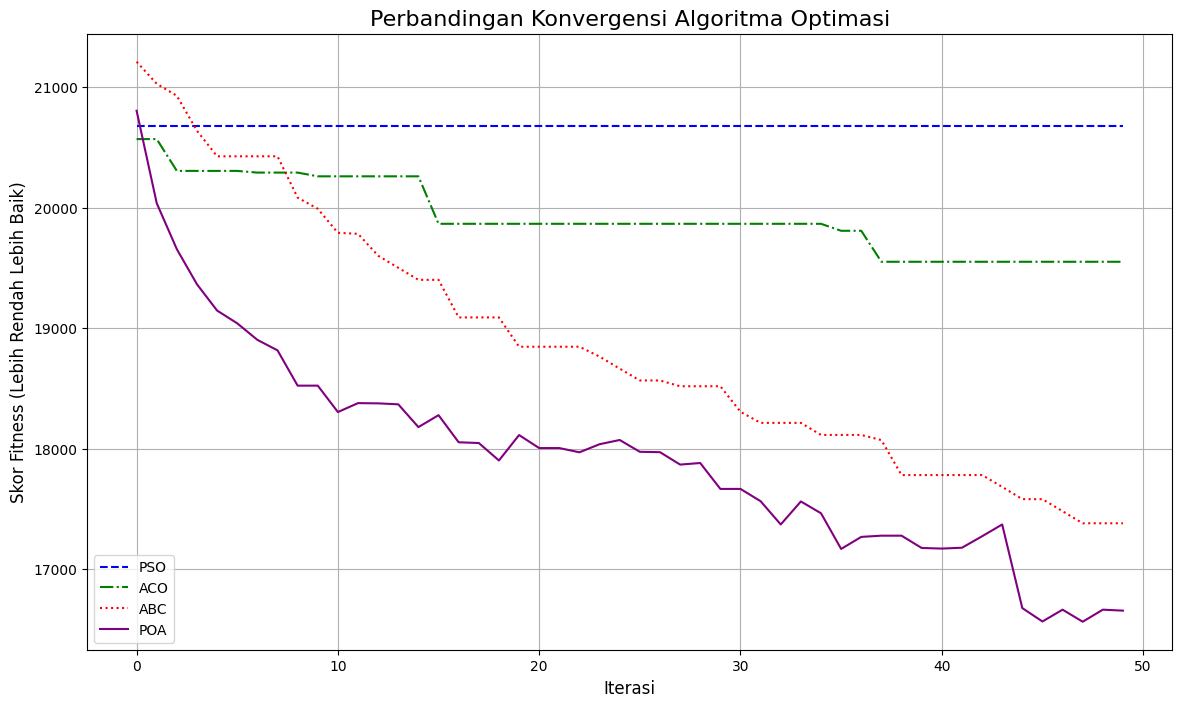


Grafik perbandingan konvergensi disimpan sebagai 'convergence_comparison.png'


In [43]:
print("\n--- PERBANDINGAN HASIL AKHIR ---")
results = {
    "Algorithm": ["PSO", "ACO", "ABC", "POA"],
    "Best Fitness Score": [pso_fitness, aco_fitness, abc_fitness, poa_fitness],
    "Hard Constraint Violations": [pso_violations, aco_violations, abc_violations, poa_violations]
}
df_results = pd.DataFrame(results)
print(df_results.to_string())

# Plotting Konvergensi
plt.figure(figsize=(14, 8))
plt.plot(pso_history, label="PSO", color="blue", linestyle='--')
plt.plot(aco_history, label="ACO", color="green", linestyle='-.')
plt.plot(abc_history, label="ABC", color="red", linestyle=':')
plt.plot(poa_history, label="POA", color="purple", linestyle='-')

plt.title("Perbandingan Konvergensi Algoritma Optimasi", fontsize=16)
plt.xlabel("Iterasi", fontsize=12)
plt.ylabel("Skor Fitness (Lebih Rendah Lebih Baik)", fontsize=12)
plt.legend()
plt.grid(True)
img = 4
plt.savefig("convergence_comparison_{img}.png")
plt.show()

print("\nGrafik perbandingan konvergensi disimpan sebagai 'convergence_comparison.png'")